<a href="https://colab.research.google.com/github/H12838/deepfake_detector-google-colab-/blob/main/deepfake_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mtcnn
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.6 MB/s eta 0:00:00


#`import`s

In [ ]:
import os
import glob
import csv
import cv2
import zipfile
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from mtcnn import MTCNN
from time import time, strftime, localtime
from shutil import rmtree, copytree, copy
from math import degrees, atan
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

#上傳檔案

In [ ]:
# 掛載 google drive
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/')

Mounted at /content/drive


#路徑

In [ ]:
prefix = r'/tmp/deepfake_project'
if not os.path.exists(prefix):
  os.mkdir(prefix)

In [ ]:
videos_path = os.path.abspath(r'/content/drive/MyDrive/專題/deepfake/demo/video')
img_path = os.path.abspath(r'/content/drive/MyDrive/專題/deepfake/demo/img')
# -------------------------------------------------資料預處理--------------------------------------------------------
videos_src_path = os.path.abspath(rf'{prefix}/videos/') # 要抽幀的影片所存放的資料夾
img_src_path = os.path.abspath(rf'{prefix}/img/') # 抽幀後的資料夾、MTCNN人臉裁切與ELA(已廢除)的圖片來源資料夾
ela_save_path = os.path.abspath(rf'{prefix}/ELA/') # ELA完的資料夾
img_save_path = os.path.abspath(rf'{prefix}/img_drawn/') # 標記邊界框與5個關鍵點的資料夾
crop_save_path = os.path.abspath(rf'{prefix}/img_cropped/') # 存放裁切後的人臉
resaved_save_path = os.path.abspath(rf'{prefix}/img_resaved/') # ELA中的一個步驟
resized_save_path = os.path.abspath(rf'{prefix}/img_resized/') # resize後的資料夾
prefix = os.path.basename(os.getcwd()) # 獲取該執行目錄的名稱
frame_split_time = 1 # frame_extractor 取幀間隔，0 代表關閉 frame_extractor
# --------------------------------------------------圖形預測---------------------------------------------------------
zip_path = r'/content/drive/MyDrive/專題/deepfake/deepfake_trained_result/DFDC_resized.zip' # 壓縮檔路徑
unzip_path = r'/tmp' # 解壓縮路徑
weight_path = r'/content/drive/MyDrive/專題/deepfake/deepfake_trained_result/InceptionResNetV2/20220131_20epoch_acc 0.9911/InceptionResNetV2_retrained_v2.h5' # 權重路徑
csv_path = r'/tmp/real.csv' # csv 路徑

In [ ]:
if not os.path.exists(videos_src_path):
  os.mkdir(videos_src_path)
if not os.path.exists(img_src_path):
  os.mkdir(img_src_path)

#def

In [ ]:
def copytree(src,dst):
    dirs = os.listdir(src)
    print(dirs)
    for dir in dirs:
        from_dir = os.path.join(src,dir)
        to_dir = os.path.join(dst,dir)
        if os.path.isdir(from_dir):
            if not os.path.exists(to_dir):
                os.mkdir(to_dir)
            copytree(from_dir,to_dir)
        elif os.path.isfile(from_dir):
            copy(from_dir,to_dir)

In [ ]:
def frame_extractor(videos_src_path, img_save_path, numbers):
    video_list = glob.iglob(rf'{videos_src_path}/**/*.mp4', recursive=True)

    for f in video_list:
        tmp = f.strip('.mp4')

        img_path = tmp.replace(videos_src_path, img_src_path) # 將 ./video/ 替換為 ./img/
        cropped_path = tmp.replace(videos_src_path, crop_save_path)
        drawn_path = tmp.replace(videos_src_path, img_save_path)
        resized_path = tmp.replace(videos_src_path, resized_save_path)

        if not os.path.exists(img_path):
            os.makedirs(img_path)
        if not os.path.exists(cropped_path):
            os.makedirs(cropped_path)
        if not os.path.exists(drawn_path):
            os.makedirs(drawn_path)
        if not os.path.exists(resized_path):
            os.makedirs(resized_path)

        cap = cv2.VideoCapture(f)
        frames_num = cap.get(7) # 獲取幀數
        rate = cap.get(5) # 獲取幀率
        if rate == 0:
            continue
        duration = round(frames_num / rate) # 獲取秒數
        c = 0
        j = 0
        ret = True
        print(f'{f}\n{duration}s / {rate}fps')
        while ret: # 當 duration >= 20 = true 時
            ret, frame = cap.read()
            if frame is None:
                continue
            c += 1
            if c % numbers == 0: # 如果 c 整除 numbers，代表這個 "c" 正好就是要提取的那一幀
                j += 1
                if j <= frames_num * rate:
                    cv2.imencode('.png', frame)[1].tofile(img_path + '/' + '{}.png'.format(c))
    print('All is done ,thanks')

In [ ]:
def image_resizer(source_path, save_path, height, width): # height: 垂直高度，width: 水平寬度，(height, width) = 圖片處理後的大小

    image = cv2.imread(source_path)
    size = image.shape # 原圖的尺寸
    h = size[0]
    w = size[1]
    if h / w > 1: # 高度大於寬度
        rate = height / h

    elif w / h == 1: # 正方形
        rate = height / h

    elif 0 < h / w < 1: # 高度小於寬度
        rate = width / h

    else:
        print(f'錯誤')

    print(f'{source_path}\n({w}, {h}) -> ({w * rate}, {h * rate})')
    if rate > 1:
        new_image = cv2.resize(image, (round(w * rate), round(h * rate)), interpolation=cv2.INTER_CUBIC)
        if h / w > 1:
            save_image = cv2.copyMakeBorder(new_image, 0, 0, 0, width - round(w * rate), cv2.BORDER_CONSTANT,value=[0,0,0])

        elif h / w ==1:
            save_image = new_image

        elif 0 < h / w < 1:
            save_image = cv2.copyMakeBorder(new_image, 0, height - round(h * rate), 0, 0, cv2.BORDER_CONSTANT,value=[0,0,0])
        cv2.imwrite(save_path, save_image)

    elif rate < 1:
        new_image = cv2.resize(image, (round(w * rate), round(h*rate)), interpolation=cv2.INTER_AREA)
        if h / w > 1:
            save_image = cv2.copyMakeBorder(new_image, 0, 0, 0, width - round(w * rate), cv2.BORDER_CONSTANT,value=[0,0,0])

        elif h / w ==1:
            save_image = new_image

        elif 0 < h / w < 1:
            save_image = cv2.copyMakeBorder(new_image, 0, height - round(h * rate), 0, 0, cv2.BORDER_CONSTANT,value=[0,0,0])

        cv2.imwrite(save_path, save_image)

In [ ]:
def bbox_expander(sth, rate):
     bbox_list = []
     bbox_dict = {}

     if sth != []:
          for i in range(len(sth)):
               expanded_bbox = []

               bbox_list = sth[i]['box']

               for j in range(len(bbox_list)):
                    bbox_list[j] = float(bbox_list[j])

               # bbox_list = [start_x, start_y, h(長), w(寬)]

               middle_y = float(bbox_list[1] + bbox_list[3] / 2)
               middle_x = float(bbox_list[0] + bbox_list[2] / 2)

               start_x = int((bbox_list[0] - middle_x) * (rate - 1) + bbox_list[0])
               start_y = int((bbox_list[1] - middle_y) * (rate - 1) + bbox_list[1])

               if start_x < 0:
                    start_x = 0
               if start_y < 0:
                    start_y = 0

               h = int(round(bbox_list[2] * rate))
               w = int(round(bbox_list[3] * rate))

               expanded_bbox.extend([start_x, start_y, h, w])
               face_num = 'face_' + str(i + 1)
               bbox_dict[face_num] = expanded_bbox
               # print(f'bbox_dict={bbox_dict}')
          return bbox_dict

     else:
          return []

In [ ]:
def chart_drawer(x_data, y_data, x_label, y_label, line_label, title, path, format):
  # 畫出acc學習曲線
  plt.plot(x_data, y_data, color='#6495ED', marker='None', label=line_label)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend(loc='lower right')
  plt.grid()
  # 儲存acc學習曲線
  plt.savefig(path, format=format)
  plt.show()

In [ ]:
copytree(videos_path, videos_src_path)
copytree(img_path, img_src_path)
print(f'found {len(os.listdir(videos_src_path))} video(s)')
print(f'found {len(os.listdir(img_src_path))} image(s)')

['媒體1.mp4', 'You Won’t Believe What Obama Says In This Video! 😉.mp4']
['musk.jpeg']
found 2 video(s)
found 1 image(s)


In [ ]:
frame_extractor(videos_src_path, img_src_path, frame_split_time)

/tmp/deepfake_project/videos/You Won’t Believe What Obama Says In This Video! 😉.mp4
72s / 23.976023976023978fps
/tmp/deepfake_project/videos/媒體1.mp4
10s / 30.0fps
All is done ,thanks


#mtcnn

In [ ]:
detector = MTCNN()

time_sum = 0
image_count = 0
video_count = 0 # 影片編號

img_list = sorted(glob.iglob(rf'{img_src_path}/**/*.png', recursive=True), key = os.path.getmtime) # 圖片列表

for each_image in img_list:
    video_count += 1

    image = cv2.imread(each_image, cv2.COLOR_BGR2RGB) # 讀取幀
    ori_image = cv2.imread(each_image, cv2.COLOR_BGR2RGB)
    image_count += 1
    start = time()
    print(f'MTCNN: {each_image}')

    result = detector.detect_faces(image)
    # new_box = bbox_expander(result, 1.3)

    circle_arr = []
    # frame_arr = []  # [[start_x, start_y, end_x, end_y]]
    ori_frame_arr = [] # 原本的邊界框
    prefix = os.path.basename(os.getcwd())
    tmp = each_image.strip('.mp4') # 將 .mp4 去掉
    drawn = tmp.replace(img_src_path, img_save_path) # 將 ./img/ 替換成 ./img_drawn/
    for i in range(len(result)):
    #     face_num = 'face_' + str(i + 1)
    #     border_box = new_box[face_num]
    #     border_box[2] = new_box[face_num][0] + new_box[face_num][2]
    #     border_box[3] = new_box[face_num][1] + new_box[face_num][3]
    #     frame_arr.append(border_box)
    #     cv2.rectangle(image,
    #                 (frame_arr[i][0], frame_arr[i][1]),
    #                 (frame_arr[i][2], frame_arr[i][3]),
    #                 (255,127,0),
    #                 2)
        ori_bbox = result[i]["box"]
        ori_bbox[2] = result[i]["box"][0] + result[i]["box"][2]
        ori_bbox[3] = result[i]["box"][1] + result[i]["box"][3]
        ori_frame_arr.append(ori_bbox)
        circle_arr.append(result[i]['keypoints'])
        cv2.rectangle(image,
                    (int(ori_frame_arr[i][0]), int(ori_frame_arr[i][1])),
                    (int(ori_frame_arr[i][2]), int(ori_frame_arr[i][3])),
                    (0,155,255),
                    2)
        tmp = tmp.replace(img_src_path, crop_save_path)
        tmp = tmp.strip('.png')
        cropped = tmp + "-" + str(i + 1) + ".png"
        crop_img = ori_image[ori_frame_arr[i][1]:ori_frame_arr[i][3], ori_frame_arr[i][0]:  ori_frame_arr[i][2]]
        cv2.circle(image, (circle_arr[i]['left_eye']), 2, (0,155,255), 2)
        cv2.circle(image, (circle_arr[i]['right_eye']), 2, (0,155,255), 2)
        cv2.circle(image, (circle_arr[i]['nose']), 2, (0,155,255), 2)
        cv2.circle(image, (circle_arr[i]['mouth_left']), 2, (0,155,255), 2)
        cv2.circle(image, (circle_arr[i]['mouth_right']), 2, (0,155,255), 2)
        cv2.imwrite(cropped, crop_img)
        # print('cropped')
    if len(result) == 0 and os.path.isfile(each_image):
        print(f'no founded faces, removed')
        os.remove(each_image)
    elif len(result) > 0 and os.path.isfile(each_image):
        print("founded faces: " + str(len(ori_frame_arr))) # 印出偵測到的人臉數量

    cv2.imwrite(drawn, image)
    # print('drawn')

    end1 = time()


    print(f'time consuming: { round((end1 - start) * 1000) } ms ')

MTCNN: /tmp/deepfake_project/img/You Won’t Believe What Obama Says In This Video! 😉/1.png
1/1 [==============================] - 0s 142ms/step
no founded faces, removed
time consuming: 12801 ms 
MTCNN: /tmp/deepfake_project/img/You Won’t Believe What Obama Says In This Video! 😉/2.png
1/1 [==============================] - 0s 29ms/step
no founded faces, removed
time consuming: 1113 ms 
MTCNN: /tmp/deepfake_project/img/You Won’t Believe What Obama Says In This Video! 😉/3.png
1/1 [==============================] - 0s 26ms/step
no founded faces, removed
time consuming: 1120 ms 
MTCNN: /tmp/deepfake_project/img/You Won’t Believe What Obama Says In This Video! 😉/4.png
1/1 [==============================] - 0s 18ms/step
no founded faces, removed
time consuming: 906 ms 
MTCNN: /tmp/deepfake_project/img/You Won’t Believe What Obama Says In This Video! 😉/5.png
1/1 [==============================] - 0s 24ms/step
no founded faces, removed
time consuming: 765 ms 
MTCNN: /tmp/deepfake_project/img/Yo

KeyboardInterrupt: ignored

In [ ]:
cropped_list = sorted(glob.iglob(rf'{crop_save_path}/**/*.png', recursive=True), key = os.path.getmtime)
for cropped_image in cropped_list:
    resized_image = cropped_image.replace(crop_save_path, resized_save_path)
    tmp = resized_image.strip('.mp4')
    image_resizer(cropped_image, resized_image, 256, 256)

/tmp/deepfake_project/img_cropped/You Won’t Believe What Obama Says In This Video! 😉/11-1.png
(198, 250) -> (202.752, 256.0)
/tmp/deepfake_project/img_cropped/You Won’t Believe What Obama Says In This Video! 😉/12-1.png
(208, 264) -> (201.6969696969697, 256.0)
/tmp/deepfake_project/img_cropped/You Won’t Believe What Obama Says In This Video! 😉/13-1.png
(195, 247) -> (202.10526315789474, 256.0)
/tmp/deepfake_project/img_cropped/You Won’t Believe What Obama Says In This Video! 😉/14-1.png
(188, 240) -> (200.53333333333333, 256.0)
/tmp/deepfake_project/img_cropped/You Won’t Believe What Obama Says In This Video! 😉/15-1.png
(185, 240) -> (197.33333333333334, 256.0)
/tmp/deepfake_project/img_cropped/You Won’t Believe What Obama Says In This Video! 😉/16-1.png
(187, 242) -> (197.8181818181818, 256.0)
/tmp/deepfake_project/img_cropped/You Won’t Believe What Obama Says In This Video! 😉/17-1.png
(186, 242) -> (196.7603305785124, 256.0)
/tmp/deepfake_project/img_cropped/You Won’t Believe What Obama

# predict

In [ ]:
model = load_model(weight_path)
input_shape = model.input_shape[1:3]

def predict(path, thresh=0.5):
  img = load_img(path, target_size=input_shape, )
  img = img_to_array(img) / 255.
  conf = model.predict(img.reshape(-1, *img.shape))[0][0]
  animal = 'real' if conf < thresh else 'fake'
  return (animal, conf)

In [ ]:
os.chdir(resized_save_path)
!ls
a = input('請選擇你要偵測的影像位址')

'You Won’t Believe What Obama Says In This Video! 😉'   媒體1
請選擇你要偵測的影像位址You Won’t Believe What Obama Says In This Video! 😉


In [ ]:
#建立 conf_arr
cap = cv2.VideoCapture(rf'{videos_src_path}/{a}.mp4')
frames_num = int(cap.get(7))
conf_arr = list()
conf_arr = [None] * frames_num

1/1 [==============================] - 5s 5s/step
/tmp/deepfake_project/img_resized/You Won’t Believe What Obama Says In This Video! 😉/11-1.png
fake / 0.7831438183784485 / 5029 ms
1/1 [==============================] - 0s 39ms/step
/tmp/deepfake_project/img_resized/You Won’t Believe What Obama Says In This Video! 😉/12-1.png
fake / 0.6548770070075989 / 93 ms
1/1 [==============================] - 0s 39ms/step
/tmp/deepfake_project/img_resized/You Won’t Believe What Obama Says In This Video! 😉/13-1.png
fake / 0.7864589095115662 / 89 ms
1/1 [==============================] - 0s 36ms/step
/tmp/deepfake_project/img_resized/You Won’t Believe What Obama Says In This Video! 😉/14-1.png
fake / 0.863469123840332 / 126 ms
1/1 [==============================] - 0s 42ms/step
/tmp/deepfake_project/img_resized/You Won’t Believe What Obama Says In This Video! 😉/15-1.png
fake / 0.9373149275779724 / 93 ms
1/1 [==============================] - 0s 40ms/step
/tmp/deepfake_project/img_resized/You Won’t Beli

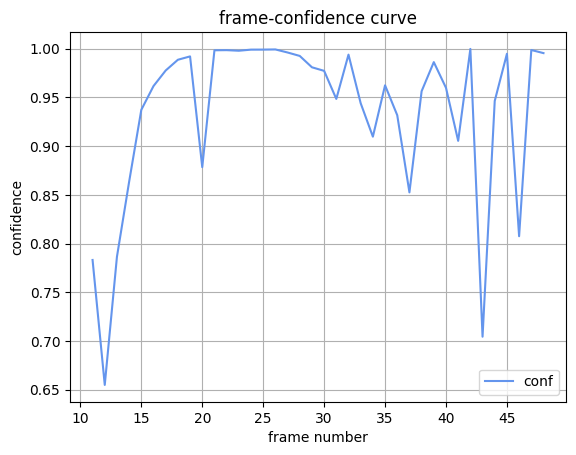

total：38
real(預測)：0
fake(預測)：38


In [ ]:
# 預測影片
predict_list = sorted(glob.iglob(rf'{resized_save_path}/{a}/**/*.png', recursive=True), key = os.path.getmtime)
image_count = 0
real_count = 0
fake_count = 0

for each_image in predict_list:
    tmp = each_image.split('/')[-1] # .../2-1.png -> 2-1.png
    tmp1 = tmp.split('.')[0] # 2-1.png -> 2-1
    image_number = tmp1.split('-')[0] # 2-1 -> 2

    start = time()
    status, conf = predict(each_image)
    end = time()
    image_count += 1
    proced_time = round((end - start) * 1000)
    video_id = each_image.split('/')[-2]
    conf_arr[int(image_number) - 1] = conf
    if status == 'real':
      real_count += 1
    elif status == 'fake':
      fake_count += 1

    print(f'{each_image}\n{status} / {conf} / {proced_time} ms')
frame_number = range(frame_split_time, frame_split_time * (len(conf_arr) + 1), frame_split_time)
chart_drawer(frame_number, conf_arr, 'frame number', 'confidence', 'conf', 'frame-confidence curve', r'/tmp/deepfake_project/img_resized/result.svg', 'svg')
print(f'total：{image_count}\nreal(預測)：{real_count}\nfake(預測)：{fake_count}')

In [ ]:
# 預測圖片
predict_list = sorted(glob.iglob(rf'{resized_save_path}/*.png', recursive=True), key = os.path.getmtime)
for each_image in predict_list:
    start = time()
    status, conf = predict(each_image)
    end = time()
    image_count += 1
    proced_time = round((end - start) * 1000)
    video_id = each_image.split('/')[-2]

    print(f'{each_image}\n{status} / {conf} / {proced_time} ms')

In [ ]:
for each_image in predict_list:
  tmp = each_image.split('/')[-1] # .../2-1.png -> 2-1.png
  tmp1 = tmp.split('.')[0] # 2-1.png -> 2-1
  image_number = tmp1.split('-')[0] # 2-1 -> 2
  print(image_number)

In [ ]:
print(len(frame_number))

In [ ]:
print(len(conf_arr))

In [ ]:
print(frame_number)

In [ ]:
print(conf_arr)

In [ ]:
print(image_nubmer)

In [ ]:
os.chdir(r'/tmp/deepfake_project')
!zip -r img.zip img

In [ ]:
!rm -rf /tmp/deepfake_project